In [2]:
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import cv2
from matplotlib import pyplot as plt
#PyTesseract
import pytesseract
#Keras-OCR
from keras_ocr import pipeline

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
#loading EasyOCR separately, to avoid dead kernel issues.
#EasyOCR
import easyocr

In [4]:
def on_upload_change(change):
    uploaded_filename = next(iter(uploader.value))
    uploaded_filename = uploader.value[0]['name']
    content = uploader.value[0]['content']
    with open(uploaded_filename, 'wb') as f:
        f.write(content)
    print(f"Uploaded file: {uploaded_filename}")
    
    try:
        display(Image(filename=uploaded_filename))
        image = cv2.imread(uploaded_filename)
    except Exception as e:
        print("Error:", e)
    return uploaded_filename,image

In [5]:
def pad_image(image, percentage=15):
    height, width, _ = image.shape
    pad_value = int((percentage/100 ) * height) 
    white = [0,0,0]
    padded_image = cv2.copyMakeBorder(image, pad_value, pad_value, pad_value, pad_value, cv2.BORDER_CONSTANT,value=white)
    return padded_image

In [6]:
def write_text(padded_image,ocr_text):
    image_with_text = padded_image.copy()
    # Write text on padded image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_color = (255, 255, 255)  # White color
    text_size = 3
    text_thickness = 3
    cv2.putText(image_with_text, ocr_text, (30, 100), font, text_size, text_color, text_thickness)
    return image_with_text

In [7]:
def preprocessing(original):
    image = original.copy()
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   
    # Apply noise reduction using Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Perform thresholding
    _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Perform text segmentation
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours around the segmented text
    segmented_image = image.copy()
    cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)

    # Display the results
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(2, 2, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title('Grayscale Image')

    plt.subplot(2, 2, 3)
    plt.imshow(blurred_image, cmap='gray')
    plt.title('Noise Reduction (Gaussian Blur)')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title('Text Segmentation')

    plt.show()
    return gray_image,blurred_image,segmented_image

In [43]:
def draw_rectangles(ocr,image,uploaded_filename=None):
    image_rect = image.copy()
    text = ''
    label = ''
    if ocr == 1: #EasyOCR
        label = 'EasyOCR'
        reader = easyocr.Reader(['en'])
        results = reader.readtext(image)
        for detection in results:
            # Get the coordinates of the bounding box
            top_left = np.array(detection[0][0])
            top_left = top_left.astype(int) 
            top_left = tuple(top_left)
            bottom_right = np.array(detection[0][2])
            bottom_right = bottom_right.astype(int) 
            bottom_right = tuple(bottom_right)
            text = text + ' ' + detection[1]
            # Draw the rectangle
            cv2.rectangle(image_rect, top_left, bottom_right, (0, 255, 0), 2)
    elif ocr ==2: #Keras_OCR
        #Keras-OCR
        label = 'Keras-OCR'
        ocr_pipeline = pipeline.Pipeline()
        prediction_groups = ocr_pipeline.recognize([image])
        #else:
        #    return
        for predictions in prediction_groups:
            for text_result in predictions:
                # Get the coordinates of the bounding box
                top_left = np.array(text_result[1][0])
                top_left = top_left.astype(int) 
                top_left = tuple(top_left)
                bottom_right = np.array(text_result[1][2])
                bottom_right = bottom_right.astype(int) 
                bottom_right = tuple(bottom_right)
                text = text + ' ' + text_result[0]
                # Draw the rectangle
                cv2.rectangle(image_rect, top_left, bottom_right, (0, 255, 0), 2)
     # Pad the image
    #image_rect = pad_image(image_rect)            
    #image_with_text = write_text(image_rect,text)
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    #ax = fig.add_subplot(121)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image_rect, cv2.COLOR_BGR2RGB))
    title = label + ' Detected Text: ' 
    #title = title + text
    plt.title(title)
    #plt.text(-1, 0,title, style='oblique', ha='left', va='top', wrap=True)
    print(label," Detected Text: ",text)
    output = ''
    output = output + label + '_' + str(uploaded_filename)
    plt.savefig(output)
    #return image_with_text

In [9]:
def text_extraction(image):
    #pytesseract
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    pytesseract_text = pytesseract.image_to_string(image)
    #easyocr
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image)
    easyocr_text = " ".join([word[1] for word in result])
    #Keras-OCR
    ocr_pipeline = pipeline.Pipeline()
    prediction_groups = ocr_pipeline.recognize([image])
    Keras_text = prediction_groups[0]
    return pytesseract_text,easyocr_text,Keras_text

In [10]:
uploader = widgets.FileUpload(accept='.jpg', multiple=False)  # Accept only JPG files
uploader.observe(on_upload_change, names='_counter')
display(uploader)

FileUpload(value=(), accept='.jpg', description='Upload')

Uploaded file: s-l400.jpg


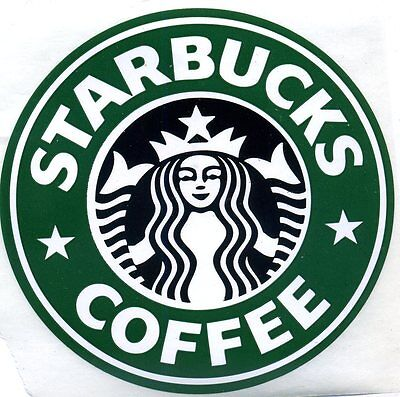

In [82]:
uploaded_filename,image = on_upload_change(None)

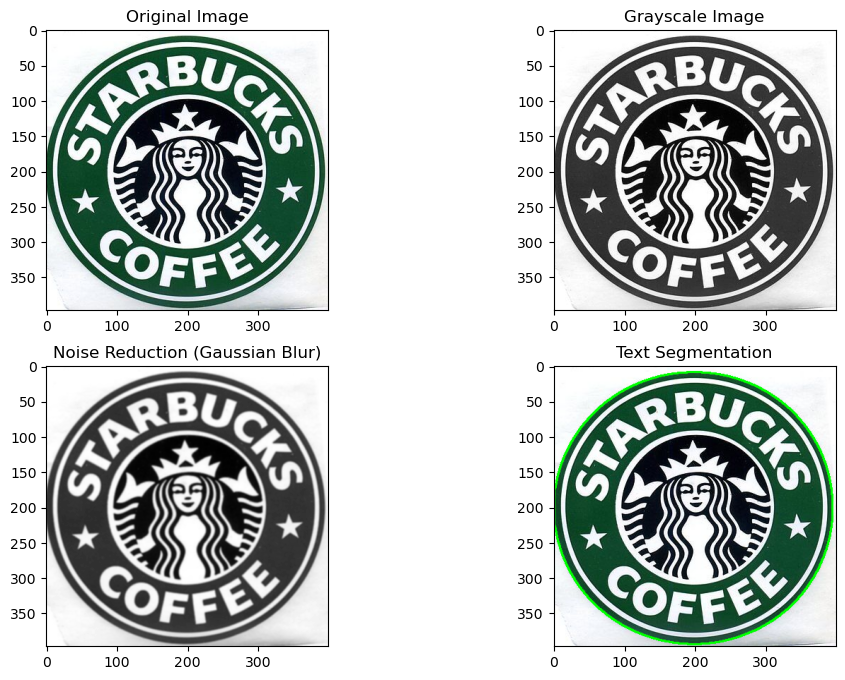

In [83]:
gray_image,blurred_image,segmented_image = preprocessing(image)

In [84]:
#pytesseract_text,easyocr_text,Keras_text = text_extraction(segmented_image)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Looking for C:\Users\shain\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\shain\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


In [85]:
#pytesseract_text

''

In [86]:
#easyocr_text

'GGaA CortEY'

In [87]:
#Keras_text

[('irebe',
  array([[ 23.080502,  42.583458],
         [358.83932 ,  27.686317],
         [365.52823 , 178.44415 ],
         [ 29.76941 , 193.34128 ]], dtype=float32)),
 ('coffes',
  array([[ 77.049706, 283.41748 ],
         [327.48892 , 277.24902 ],
         [329.6962  , 366.86462 ],
         [ 79.25699 , 373.03308 ]], dtype=float32))]

In [88]:
uploaded_filename

's-l400.jpg'

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


EasyOCR  Detected Text:   SALSA c 4 5.148  5 FL- TAPAR PICANTE Hot:


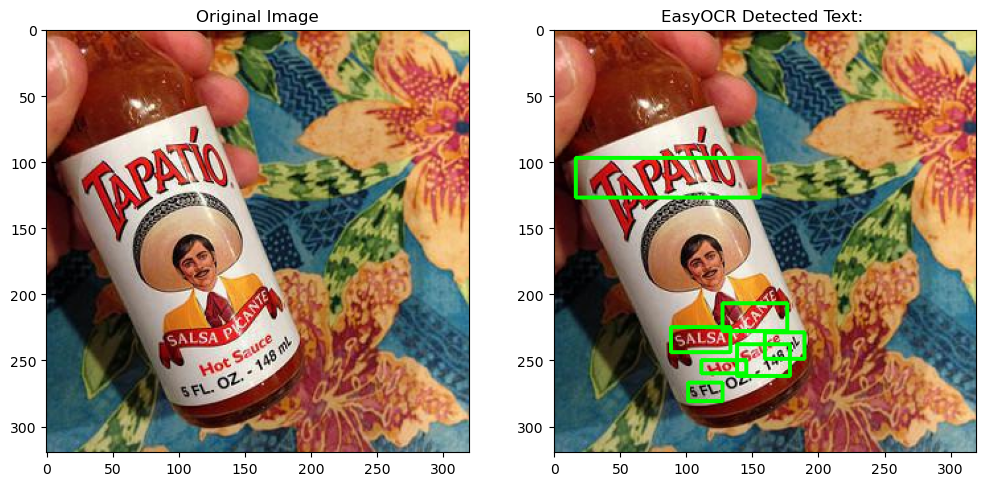

In [80]:
ocr = 1
detected = draw_rectangles(ocr,image,uploaded_filename)

Looking for C:\Users\shain\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\shain\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step
Keras-OCR  Detected Text:   tapato cante p salsa sauce ns 148 hot oz sfl


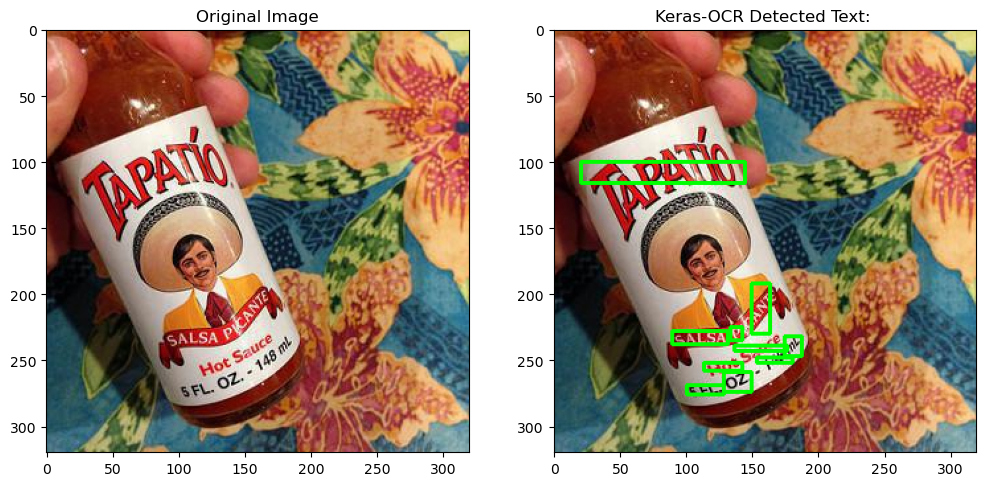

In [81]:
ocr = 2
detected = draw_rectangles(ocr,image,uploaded_filename)